# iGPU: Intel Arc 140T Mobile
- Ref: https://www.techpowerup.com/gpu-specs/arc-140t-mobile.c4268
- Max:
  - F16  : 9.6 TFLOPS
  - FP32 : 4.8 TFLOPS
  - FP64 : 1.2 TFLOPS

In [ ]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(
    f'XPU available: {torch.xpu.is_available() if hasattr(torch, "xpu") else "Unknown"}'
)

try:
    print(f"\nXPU Device count: {torch.xpu.device_count()}")
    print(f"Current XPU device: {torch.xpu.current_device()}")
    print(f"XPU device name: {torch.xpu.get_device_name()}")
    print(f"XPU device capability: {torch.xpu.get_device_capability()}")
    print(f"XPU device properties: {torch.xpu.get_device_properties()}")
    print(f"XPU memory reserved (GB): {torch.xpu.memory_reserved() / 1e9:.2f}")
except Exception as e:
    print(f"Error accessing XPU device information: {e}")

PyTorch version: 2.10.0+xpu
XPU available: True

XPU Device count: 1
Current XPU device: 0
XPU device name: Intel(R) Arc(TM) Graphics
XPU device capability: {'architecture': 13195281408, 'device_id': 32081, 'driver_version': '1.14.36300', 'gpu_eu_count': 128, 'gpu_subslice_count': 8, 'has_atomic64': True, 'has_bfloat16_conversions': True, 'has_fp16': True, 'has_fp64': True, 'has_subgroup_2d_block_io': False, 'has_subgroup_matrix_multiply_accumulate': True, 'has_subgroup_matrix_multiply_accumulate_tensor_float32': False, 'max_compute_units': 128, 'max_num_sub_groups': 128, 'max_work_group_size': 1024, 'name': 'Intel(R) Arc(TM) Graphics', 'platform_name': 'Intel(R) oneAPI Unified Runtime over Level-Zero', 'sub_group_sizes': [8, 16, 32], 'total_memory': 30653009920, 'type': 'gpu', 'vendor': 'Intel(R) Corporation', 'version': '12.74.4'}
XPU device properties: _XpuDeviceProperties(name='Intel(R) Arc(TM) Graphics', platform_name='Intel(R) oneAPI Unified Runtime over Level-Zero', type='gpu', 

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np


def benchmark_device(device, N_values, num_trials=5):
    """Benchmark matrix multiplication for different N values on specified device"""
    times = []

    for N in N_values:
        trial_times = []
        if device == "cpu" and N >= 8192:
            _nt = max(1, num_trials // 5)  # Reduce trials for large N on CPU
        else:
            _nt = num_trials

        for _ in range(_nt):
            # Create random matrices
            a = torch.randn(N, N, device=device, dtype=torch.float32)
            b = torch.randn(N, N, device=device, dtype=torch.float32)

            # Warm up (especially important for GPU)
            if device == "xpu":
                torch.xpu.synchronize()
            _ = torch.matmul(a, b)
            if device == "xpu":
                torch.xpu.synchronize()

            # Actual timing
            start_time = time.perf_counter()
            result = torch.matmul(a, b)
            if device == "xpu":
                torch.xpu.synchronize()  # Ensure GPU computation is complete
            end_time = time.perf_counter()

            trial_times.append(end_time - start_time)

        # Use median time to reduce noise
        times.append(np.median(trial_times))
        print(f"{device.upper()} N={N:4d}: {times[-1]*1000:6.2f} ms")

    return times


# Test different matrix sizes
N_values = [64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384]
print("Benchmarking CPU vs XPU performance...")
print("=" * 40)

# Benchmark CPU
print("CPU Benchmark:")
cpu_times = benchmark_device("cpu", N_values)

print("\nXPU Benchmark:")
xpu_times = benchmark_device("xpu", N_values)

# Calculate speedup
speedups = [cpu_time / xpu_time for cpu_time, xpu_time in zip(cpu_times, xpu_times)]

print("\n" + "=" * 40)
print("Performance Summary:")
print(f"{'N':>6} {'CPU (ms)':>10} {'XPU (ms)':>10} {'Speedup':>10}")
print("-" * 40)
for i, N in enumerate(N_values):
    print(
        f"{N:6d} {cpu_times[i]*1000:9.2f} {xpu_times[i]*1000:9.2f} {speedups[i]:9.2f}x"
    )

Benchmarking CPU vs XPU performance...
CPU Benchmark:
CPU N=  64:  11.95 ms
CPU N= 128:   7.00 ms
CPU N= 256:   6.03 ms
CPU N= 512:   5.98 ms
CPU N=1024:  12.00 ms
CPU N=2048:  88.79 ms
CPU N=4096: 276.40 ms
CPU N=8192: 1682.60 ms
CPU N=16384: 8972.88 ms

XPU Benchmark:
XPU N=  64:   0.22 ms
XPU N= 128:   0.25 ms
XPU N= 256:   0.30 ms
XPU N= 512:   0.43 ms
XPU N=1024:   1.65 ms
XPU N=2048:   4.09 ms
XPU N=4096:  33.52 ms
XPU N=8192: 278.16 ms
XPU N=16384: 2528.55 ms

Performance Summary:
     N   CPU (ms)   XPU (ms)    Speedup
----------------------------------------
    64     11.95      0.22     55.46x
   128      7.00      0.25     28.17x
   256      6.03      0.30     20.23x
   512      5.98      0.43     13.89x
  1024     12.00      1.65      7.30x
  2048     88.79      4.09     21.73x
  4096    276.40     33.52      8.25x
  8192   1682.60    278.16      6.05x
 16384   8972.88   2528.55      3.55x


<Figure size 1200x800 with 0 Axes>

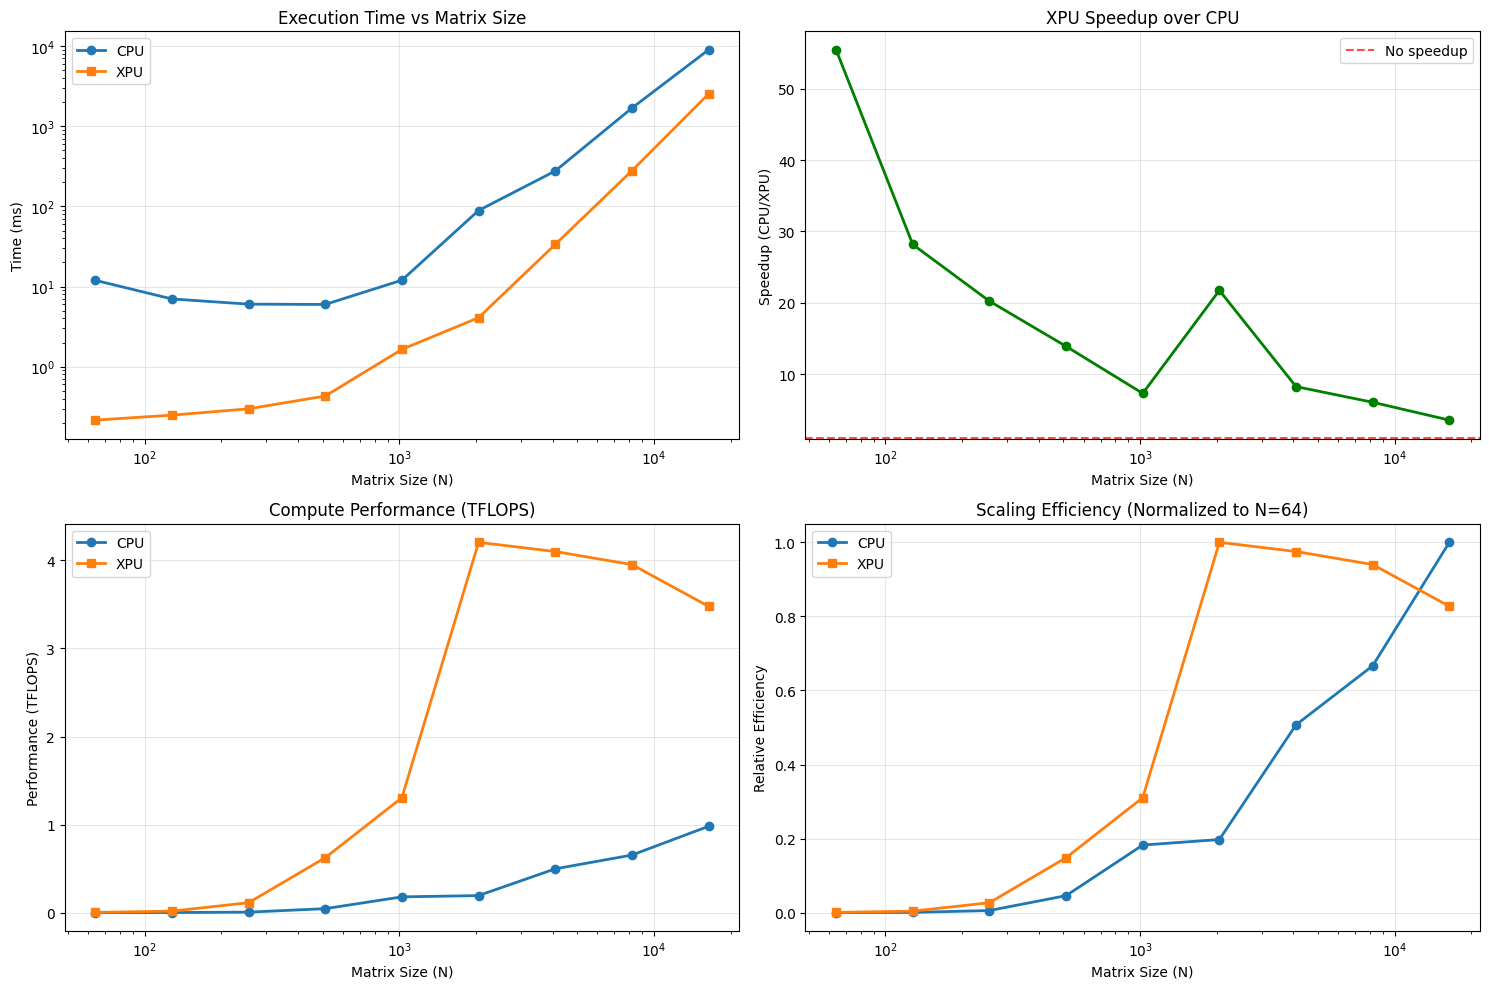


Summary Statistics:
Average speedup: 18.29x
Max speedup: 55.46x at N=64
Min speedup: 3.55x at N=16384
Peak XPU performance: 4.21 TFLOPS at N=2048
Peak CPU performance: 0.98 TFLOPS at N=16384


In [ ]:
# Plot the results
plt.figure(figsize=(12, 8))

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Execution times
ax1.loglog(N_values, [t * 1000 for t in cpu_times], "o-", label="CPU", linewidth=2)
ax1.loglog(N_values, [t * 1000 for t in xpu_times], "s-", label="XPU", linewidth=2)
ax1.set_xlabel("Matrix Size (N)")
ax1.set_ylabel("Time (ms)")
ax1.set_title("Execution Time vs Matrix Size")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Speedup
ax2.semilogx(N_values, speedups, "o-", color="green", linewidth=2)
ax2.set_xlabel("Matrix Size (N)")
ax2.set_ylabel("Speedup (CPU/XPU)")
ax2.set_title("XPU Speedup over CPU")
ax2.grid(True, alpha=0.3)
ax2.axhline(y=1, color="red", linestyle="--", alpha=0.7, label="No speedup")
ax2.legend()

# Plot 3: TFLOPS comparison
# Formula: TFLOPS = (2 * N^3) / (time_in_seconds * 1e12)
# Since each matrix multiplication does 2*N^3 operations
tflops_cpu = [(2 * N**3) / (1e12 * t) for N, t in zip(N_values, cpu_times)]
tflops_xpu = [(2 * N**3) / (1e12 * t) for N, t in zip(N_values, xpu_times)]

ax3.semilogx(N_values, tflops_cpu, "o-", label="CPU", linewidth=2)
ax3.semilogx(N_values, tflops_xpu, "s-", label="XPU", linewidth=2)
ax3.set_xlabel("Matrix Size (N)")
ax3.set_ylabel("Performance (TFLOPS)")
ax3.set_title("Compute Performance (TFLOPS)")
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Efficiency scaling
# Fomula: Efficiency = TFLOPS / Max TFLOPS observed
cpu_efficiency = [g / max(tflops_cpu) for g in tflops_cpu]
xpu_efficiency = [g / max(tflops_xpu) for g in tflops_xpu]

ax4.semilogx(N_values, cpu_efficiency, "o-", label="CPU", linewidth=2)
ax4.semilogx(N_values, xpu_efficiency, "s-", label="XPU", linewidth=2)
ax4.set_xlabel("Matrix Size (N)")
ax4.set_ylabel("Relative Efficiency")
ax4.set_title("Scaling Efficiency (Normalized to N=64)")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nSummary Statistics:")
print(f"Average speedup: {np.mean(speedups):.2f}x")
print(f"Max speedup: {np.max(speedups):.2f}x at N={N_values[np.argmax(speedups)]}")
print(f"Min speedup: {np.min(speedups):.2f}x at N={N_values[np.argmin(speedups)]}")
print(
    f"Peak XPU performance: {np.max(tflops_xpu):.2f} TFLOPS at N={N_values[np.argmax(tflops_xpu)]}"
)
print(
    f"Peak CPU performance: {np.max(tflops_cpu):.2f} TFLOPS at N={N_values[np.argmax(tflops_cpu)]}"
)